## Boring Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
logging.getLogger().setLevel(logging.INFO)

import pandas as pd
import json
import os
import trappy
from trace import Trace
from executor import Executor

## Running Workload

In [2]:
tests_conf = {
    "modules"  : [ "bl" ],
    "exclude_modules"  : [ "hwmon" ],
    "tools"    : [ "rt-app" ],
    "ftrace" : {
        "events" : [
            "sched_overutilized",
            "sched_migrate_task",
            "sched_switch",
            "cpu_idle",
            "cpu_frequency",
        ],
    },
    "wloads" : {
        "six-fivepercent" : {
            "type" : "rt-app",
            "conf" : {
                "class" : "periodic",
                "params" : {
                    "duty_cycle_pct": 5,
                    "duration_s": 5,
                    "period_ms": 10,
                },
                "tasks" : 6,
                "prefix" : "many",
            },
        },
    },
    "iterations": 3,
    "confs" : [
        {
            "tag" : "",
            "flags" : "ftrace",
            "sched_features" : "ENERGY_AWARE",
            "cpufreq" : {
                "governor" : "interactive"
            },
        }
    ]
}

executor = Executor(tests_conf=tests_conf)

05:44:12  INFO    :         Target - Loading custom (inline) test configuration
05:44:12  INFO    :         Target - Using base path: /vagrant
05:44:12  INFO    :         Target - Loading default (file) target configuration
05:44:12  INFO    :         Target - Loading target configuration [/vagrant/target.config]...
05:44:12  INFO    :         Target - Loading custom (inline) test configuration
05:44:12  INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq']
05:44:12  INFO    :         Target - Connecting linux target:
05:44:12  INFO    :         Target -   username : brendan
05:44:12  INFO    :         Target -       host : 192.168.2.2
05:44:12  INFO    :         Target -   password : password
05:44:12  INFO    :         Target - Connection settings:
05:44:12  INFO    :         Target -    {'username': u'brendan', 'host': u'192.168.2.2', 'password': u'password'}
05:44:16  INFO    :         Target - Initializing target workdir:
05:44:16  INFO    :         Target -    /hom

In [3]:
executor.run()

05:44:25  INFO    : 
05:44:25  INFO    : ################################################################################
05:44:25  INFO    :       Executor - Experiments execution
05:44:25  INFO    : ################################################################################
05:44:25  INFO    : 
05:44:25  INFO    : ================================================================================
05:44:25  INFO    :   TargetConfig - configuring target for [] experiments
05:44:27  INFO    :  SchedFeatures - Set scheduler feature: ENERGY_AWARE
05:44:28  INFO    :        CPUFreq - Configuring all CPUs to use [interactive] governor
05:44:28  INFO    :          WlGen - Setup new workload six-fivepercent
05:44:28  INFO    :          RTApp - Workload duration defined by longest task
05:44:28  INFO    :          RTApp - Default policy: SCHED_OTHER
05:44:28  INFO    :          RTApp - ------------------------
05:44:28  INFO    :          RTApp - task [many0], sched: using default policy
05:

In [8]:
events =  ["sched_overutilized", "cpu_frequency", "cpu_idle", "sched_switch"]
experiment = executor.experiments[0]
trace_path = experiment.out_dir
trace = Trace(executor.te.platform, trace_path, events)

05:46:03  INFO    : Parsing FTrace format...
05:46:03  INFO    : Platform clusters verified to be Frequency coherent
05:46:03  INFO    : Collected events spans a 10.073 [s] time interval
05:46:03  INFO    : Overutilized time: 0.908184 [s] (9.016% of trace time)
05:46:03  INFO    : Set plots time range to (0.000000, 10.073433)[s]
05:46:03  INFO    : Registering trace analysis modules:
05:46:03  INFO    :    tasks
05:46:03  INFO    :    eas
05:46:03  INFO    :    latency
05:46:03  INFO    :    frequency
05:46:03  INFO    :    functions
05:46:03  INFO    :    idle
05:46:03  INFO    :    status
05:46:03  INFO    :    cpus


In [5]:
energy_model = executor.te.nrg_model

## Alternative: Use trace from a previous automated test run

In [6]:
if False: # Un-False if you want to use this
    trace_path = "../../results_latest/rtapp::{}/1/trace.dat".format("three-twentypercent")

    platform_json_path = os.path.join(os.path.dirname(trace_path), "../platform.json")

    with open(platform_json_path) as f:
        platform = json.load(f)
    
    trace = Trace(platform, trace_path, events)

    from platforms.juno_energy import juno_energy
    energy_model = juno_energy

## Plot Schedule

In [9]:
import trappy

print "tracing " + os.path.realpath(trace_path)
trappy.plotter.plot_trace(trace.ftrace)

tracing /vagrant/results/20161025_174425/rtapp::six-fivepercent/1


## Figure out period of workload execution

In [10]:
from bart.sched.SchedMultiAssert import SchedMultiAssert

In [11]:
tasks = experiment.wload.tasks.keys()
multi_assert = SchedMultiAssert(experiment.out_dir,
                                executor.te.topology,
                               tasks)
start = min(e['starttime'] for e in multi_assert.getStartTime().values())
end = min(e['endtime'] for e in multi_assert.getEndTime().values())
window = (start, end)

## View energy estimation
`estimate_from_trace` uses the energy model to produce a trace of estimated power of each system component.
Each column is headed by a tuple with the CPUs in the component (CPU or cluster) represented. The "power" column contains the sum of the other columns.

In [12]:
power_df = energy_model.estimate_from_trace(trace)

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2824: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
05:46:15  INFO    :    EnergyModel - Estimating energy from trace - 5209 events...
05:46:25  INFO    :    EnergyModel - Done.


Now plot the energy of each component. The `cumsum` along axis 1 (the horizontal axis) means that the plots for each component are stacked. 

Working out which line is which is left as an exercise to the reader. Also we should fill under the lines with 100% opacity but I can't get the JS library to do that for me.

In [13]:
import numpy as np

In [43]:
df = power_df.drop("power", 1).apply(np.cumsum, axis=1)
print df.columns
from trappy.plotter.ILinePlotGen import ILinePlotGen
gen = ILinePlotGen(2, per_line=1, title="power", 
                   max_datapoints={}, step_plot=True, fill=False, scatter=None, point_size=1000)
gen.add_plot(1, df)
gen.finish()

Index([(0,), (1,), (2,), (3,), (4,), (5,), (0, 3, 4, 5), (1, 2)], dtype='object')


""
""
""
""


## Find which resources over-used energy

Sum the energy used by each component over the period of workload execution.

In [15]:
from bart.common.Utils import select_window, area_under_curve

In [16]:
df_windowed = select_window(power_df, window)
columns = list(df_windowed.columns)
columns.remove("power")
estimated = {}
for column in columns:
    estimated[column] = area_under_curve(df_windowed[column]) / (window[1] - window[0])
estimated

{(0,): 22.857491033923406,
 (0, 3, 4, 5): 30.199687213678327,
 (1,): 1.4318014382091142,
 (1, 2): 24.026236776919855,
 (2,): 1.2120888792342339,
 (3,): 1.7785443286179861,
 (4,): 1.9866856326455637,
 (5,): 20.698697420121484}

Get expected (ideal) energy usage

In [39]:
def task_capacity(task):
    # Must be a single-phase task
    [phase] = experiment.wload.params["profile"][task]["phases"]
    return (phase.duty_cycle_pct * energy_model.capacity_scale / 100.)

capacities = {t: task_capacity(t) for t in tasks}
_, utils = energy_model._find_optimal_placements(capacities)
util = utils[6]

05:53:27  INFO    :    EnergyModel - Searching 46656 configurations for optimal task placement...
05:53:27  INFO    :    EnergyModel - Done


In [41]:
expected = energy_model.estimate_from_cpu_util(util)
del expected["power"]
# estimate_from_cpu_util returns with an "idle" field and an "active" field, add them up
expected = { k: sum(v.values()) for k, v in expected.iteritems() }
expected

{(0,): 29.53021276595745,
 (0, 3, 4, 5): 29.855319148936168,
 (1,): 0.0,
 (1, 2): 24.0,
 (2,): 0.0,
 (3,): 0.0,
 (4,): 17.765106382978725,
 (5,): 0.0}

Show how much extra energy each component seemed to use

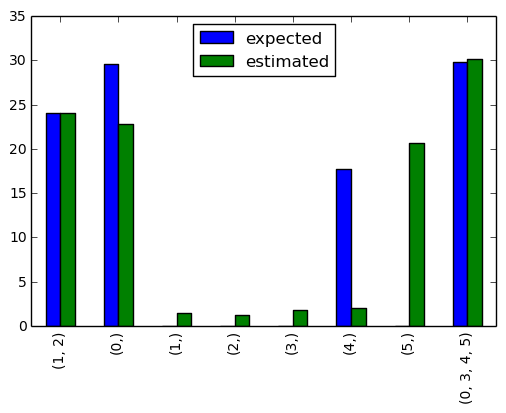

In [42]:
df_exp = pd.DataFrame(expected.values(), index=expected.keys())
df_est = pd.DataFrame(estimated.values(), index=estimated.keys())
df = pd.concat([df_exp, df_est], axis=1)
df.columns = ["expected", "estimated"]
df.plot(kind="bar")

05:47:21  INFO    : LITTLE cluster average frequency: 0.497 GHz
05:47:21  INFO    : big    cluster average frequency: 0.516 GHz


(0.49683586860207896, 0.51593129390865178)

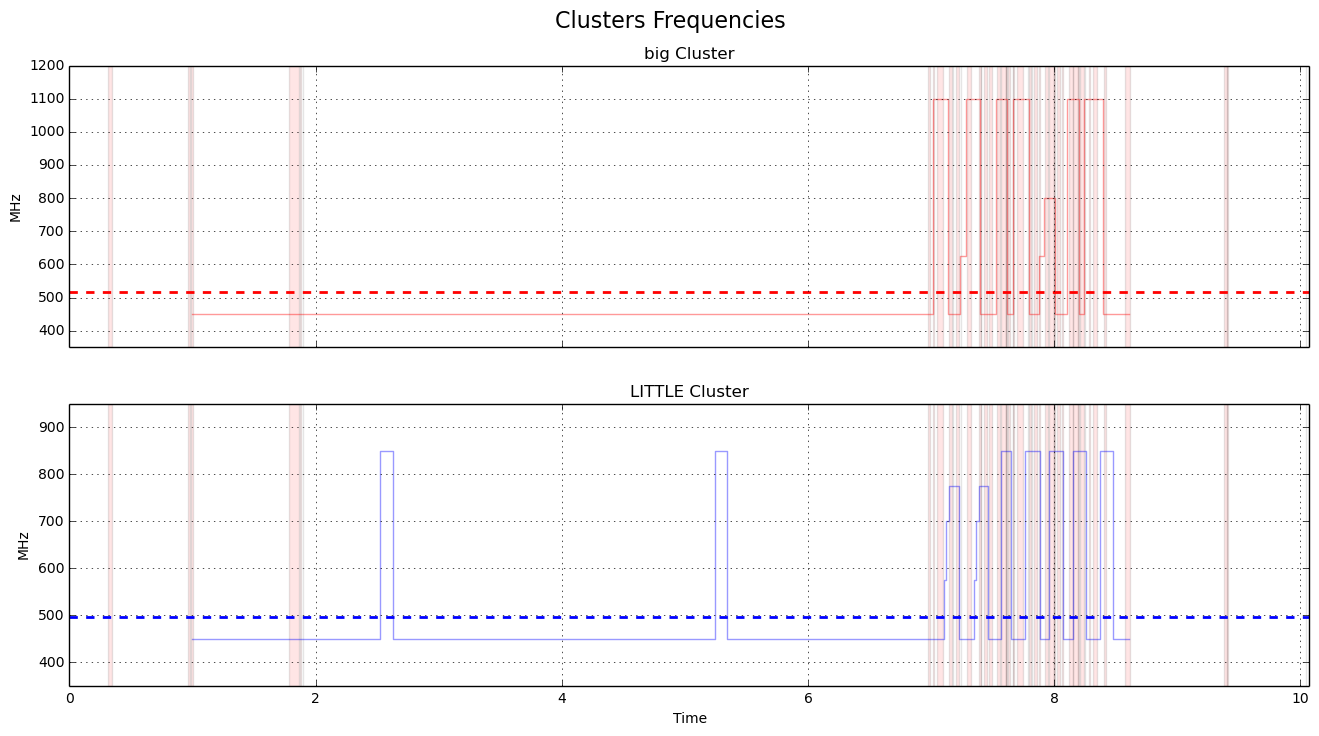

In [20]:
trace.analysis.frequency.plotClusterFrequencies()

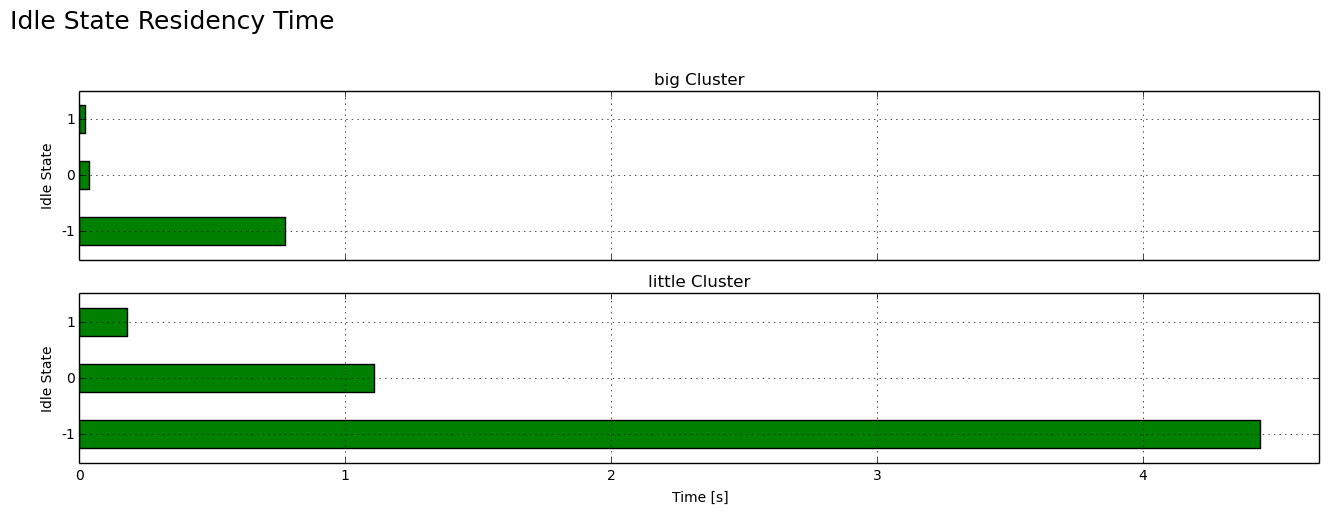

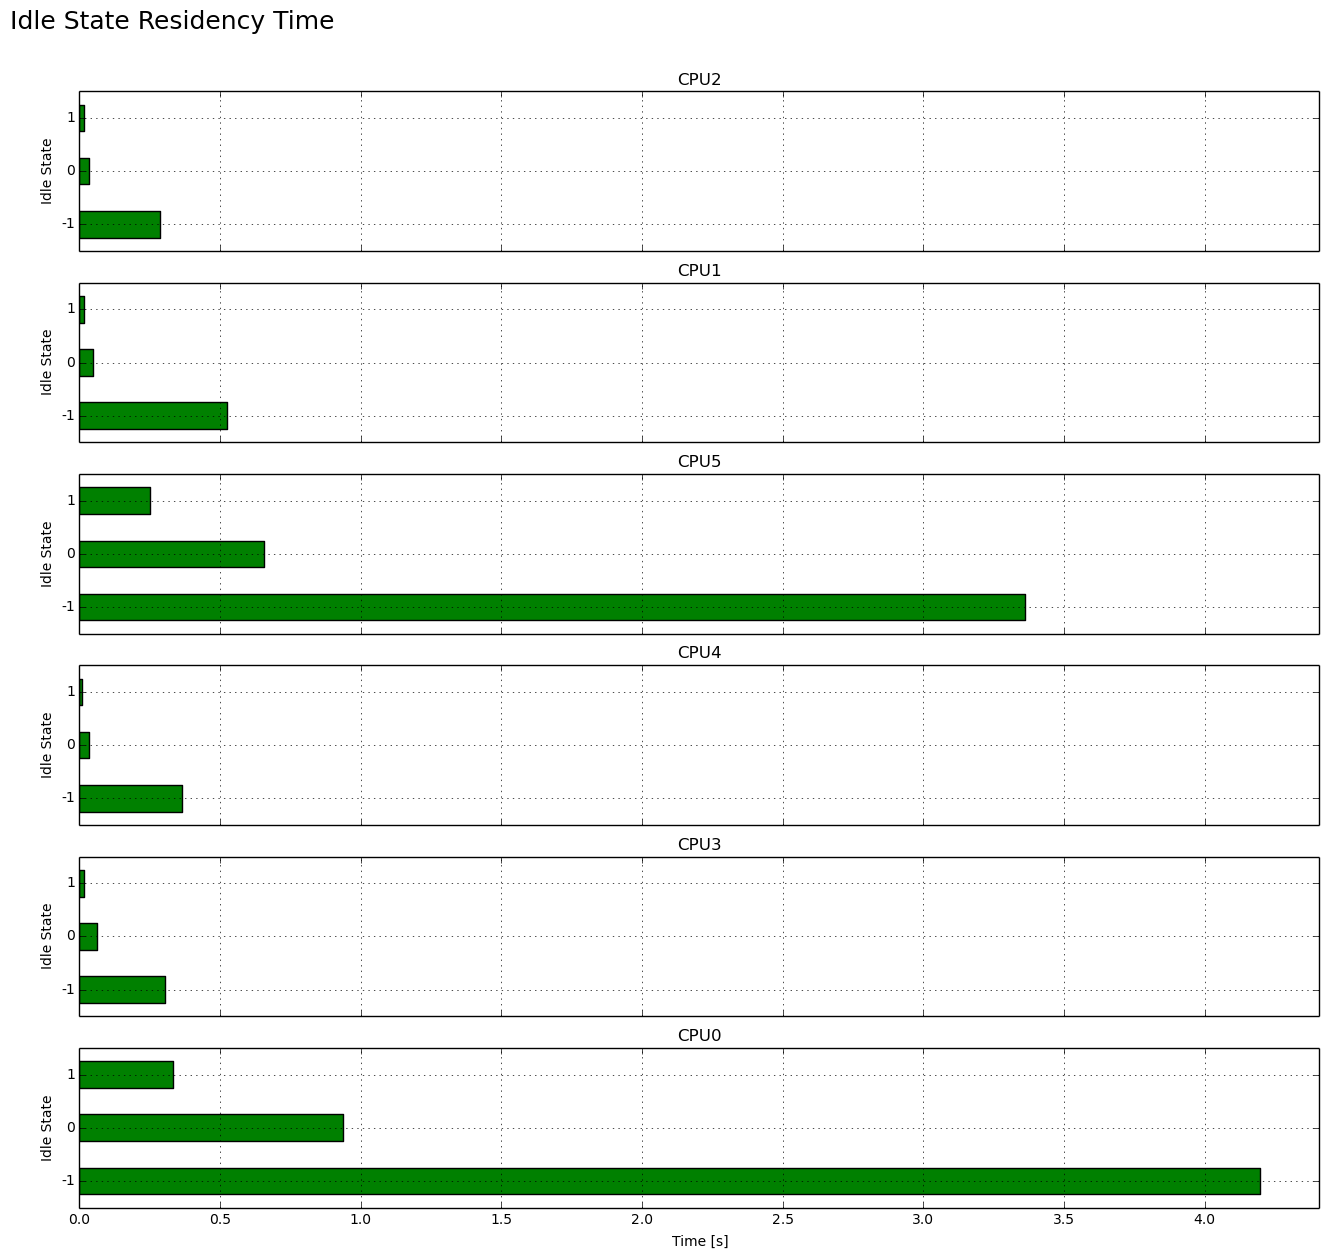

In [21]:
trace.analysis.idle.plotClusterIdleStateResidency()
trace.analysis.idle.plotCPUIdleStateResidency()